<a href="https://colab.research.google.com/github/ChrisFJardine/Masterclass/blob/main/CJardineAssignment3__Wrangling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd
import re
import time
import os
import nltk
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
%matplotlib inline 
from datetime import datetime, timedelta

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
news = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Assignment 3/ExtractedNews.csv', header = None)

In [12]:
docs = []
for x in range(news.shape[1]):
  for y in range(news.shape[0]):
    if isinstance(news[x][y], str):
      docs.append(news[x][y])
df = pd.DataFrame(docs)

In [29]:
df = pd.DataFrame(docs)
df['date'] = df[0].apply(lambda x: datetime.strptime(re.search(r'\d{4}-\d{2}-\d{2}', str(x)).group(),'%Y-%m-%d').date())
df['text'] = df[0].str.replace('[^\w\s]', '')
df['text'] = df['text'].str.replace('\d+','')
df['text'] = df['text'].str.lstrip()
df = df.drop(df.columns[[0]], 1)
df.sort_values(by='date', inplace=True)


In [14]:
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [30]:
df['sentiment'] = df.apply(lambda x: sid.polarity_scores(x.text), axis=1)
df['compound']  = df['sentiment'].apply(lambda score_dict: score_dict['compound'])


In [32]:
df_grouped = df.groupby('date').mean()


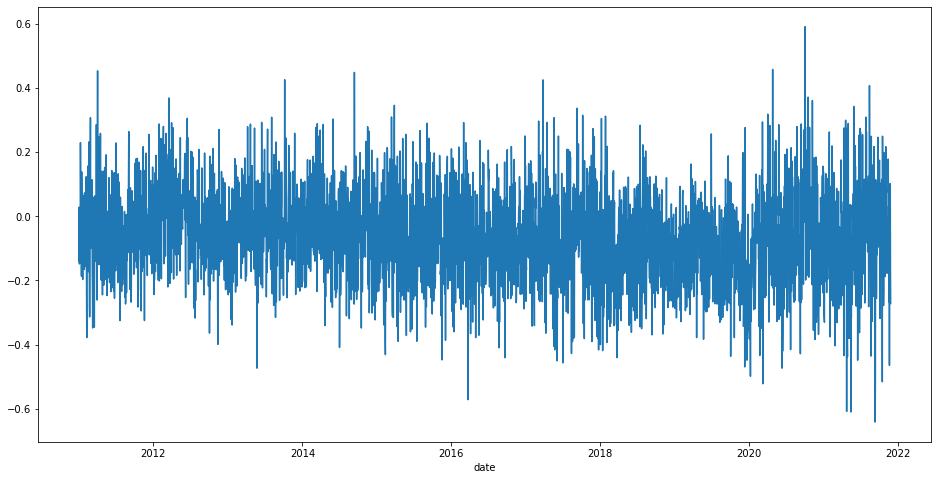

In [17]:
df_grouped['compound'].plot(figsize = (16,8))

In [38]:
df_grouped['avg'] = df_grouped['compound'].rolling(window=365).mean() 

In [1]:
df_grouped['avg'].plot(figsize = (16,8))

NameError: ignored